# Seminararbeit im Fach: Datenanalyse in der Praxis

## Thema: Beschaffung, Bereinigung und Analyse technischer Daten von Motorrädern ausgewählter Marken

### Einleitung
Das erste Motorrad der Welt wurde im Jahr 1885 von Gottlieb Daimler entwickelt, der "Daimler-Reitwagen". Es bestand aus Holz und sah auf den ersten Blick wie ein Fahrrad aus, doch hatte einen Motor mit knapp 0,5 PS und 264 cm³ Hubraum.

Seit dem hat sich in der Motorradwelt einiges getan.
Im Jahr 1999 erschien das erste über 300 km/h schnelle Serienmotorrad, die Suzuki Hayabusa 1300 mit 175 PS bei 9800 Umdrehungen pro Minute.
Doch das aktuell stärkste Motorrad auf dem Markt ist die Kawasaki Ninja H2R. Sie leistet unglaubliche 310 PS bei 14000 UPM und nur 998 cm³ Hubraum. Um zu verdeutlichen, wie viel das für ein Motorrad ist: Es bestreitet den Sprint von Tempo 0 auf 400 km/h in ca. 26 Sekunden. Zum Vergleich: Der 1500 PS starke Supersportwagen Bugatti Chiron braucht dafür ganze 32,6 Sekunden.

 Glücklicherweise haben nicht alle Motorräder solche enormen Fahrleistungen. Es fängt schon bei Motorrollern mit 50 cm³ und in etwa 3 PS an und auch darüber gibt es sehr viel Auswahl, wie später deutlich wird.
 Einige der größten Hersteller für Motorräder sind Yamaha, Honda, Kawasaki, BMW und KTM, welche ich im Folgenden behandeln werde.

### Import der wichtigsten Bibliotheken
Da der Fokus meiner Seminararbeit auf Webscraping liegen wird, importiere ich zuerst "requests" und "BeautifulSoup". "Pandas", "matplotlib.pyplot" und "seaborn" werden darüber hinaus für die Visualisierung der Daten benötigt. "re" stellt Funktionen für den Einsatz von regulären Ausdrücken zur Verfügung. Wofür ich "selenium" gebraucht habe, wird im Abschnitt "Beschaffung der Daten" ersichtlich.

In [5]:
import os
import time

import requests
from bs4 import BeautifulSoup
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

from selenium import webdriver
from selenium.webdriver.chrome.options import Options

Zuerst habe ich versucht, eine einzelne Webseite testweise herunterzuladen und dann technische Daten zu extrahieren.

In [2]:
page = requests.get("https://www.motorradonline.de/marken-modelle/ktm/390-duke/technische-daten/")
soup = BeautifulSoup(page.content, "html.parser")

## Beschaffung der Daten
Doch das hat nicht funktioniert. Komischerweise waren nicht die gleichen Daten vorhanden, wie im Browser oder wenn ich die Webseite über den Browser heruntergeladen und mit einem Texteditor angeschaut habe.
Nach etwas Recherche bin ich dann auf die Idee gekommen, testweise Javascript im Browser zu deaktivieren, wodurch ich nun das gleiche Problem im Browser hatte. Die Webseite hat nicht alle Inhalte im html-Code enthalten und der Klick auf den Button, um die technischen Daten anzuzeigen hat nicht mehr funktioniert. Das bedeutet, die Motorradmodell-spezifischen Inhalte der Webseite werden erst durch den Klick auf den "Alle Daten"-Button dynamisch geladen.
Abhilfe schafft hier das Tool Selenium, da es Aktionen auf der Webseite ausführen kann, wie beispielsweise einen Button zu drücken. Es kommuniziert durch einen Webdriver mit einem Webbrowser. Um Selenium mit Chrome zu verwenden, installiere ich zuerst den Webdriver dafür und lege ihn im Projektordner ab.

In [93]:
# Optionen instanziieren
options = Options()

# Pfad zur chrome.exe setzen
options.binary_location = "C:\Program Files\Google\Chrome\Application\chrome.exe"

# Pfad zum Webdriver setzen
chrome_driver = os.getcwd() + "\webdriver\chromedriver.exe"

# Einen Webdriver instanziieren
driver = webdriver.Chrome(options=options, executable_path=chrome_driver)

# Laden unserer HTML-Seite
driver.get("https://www.motorradonline.de/marken-modelle/ktm/390-duke/technische-daten/")

Bis hier sind wir am gleichen Punkt wie vorher. Die Webseite enthält noch nicht die benötigten Daten.
Es müssen alle "Alle Daten"-Buttons geklickt werden. Doch das gestaltet sich als nicht so einfach wie gedacht:

In [18]:
# Einen Button drücken:
element = driver.find_element_by_link_text('Alle Daten')
element.click()

Es erscheint folgende Fehlermeldung: "ElementClickInterceptedException: Message: element click intercepted".
Sie entsteht dadurch, dass das Element verdeckt ist.
Glücklicherweise lässt sich dieses Problem beheben, indem man den Klick mit Javascript hervorruft, da es nicht von der Sichtbarkeit der Webseiten-Elemente abhängig ist. Durch time.sleep hat der Driver genug Zeit, um die Webseite vollständig zu laden, andernfalls würde man wieder unvollständige Daten enthalten.

In [19]:
driver.execute_script("arguments[0].click();", element)
time.sleep(2)

Um alle Links für die einzelnen Modelle zu bekommen, wird die Marke und das Modell benötigt, da die URL folgendermaßen aufgebaut ist:
https://www.motorradonline.de/marken-modelle/[MARKE]/[MODELL]/technische-daten/

Ich möchte die Marken KTM, Yamaha, Honda, BMW und Kawasaki vergleichen. Daher legen wir deren url-Bezeichnungen in einer Liste ab.
Die Modelle werden im Gegensatz zu den Marken automatisch gesammelt, da es pro Marke sehr viele gibt und es sinnlos wäre, die Liste händisch anzulegen.
Die Links zu den Modellen sind in den "a"-Tags der Container mit den Klassennamen "v-A_-brandgeneration__container".
Um direkt auf die Seite mit den technischen Daten zu kommen, füge ich an jeden Link noch "technische-daten/" an das Ende hinzu.
Die URLs der einzelnen Marken werden schließlich zusammengefasst.

In [91]:
brands = ["ktm", "yamaha", "honda", "bmw", "kawasaki"]

# Funktion zum Erstellen der URL-Liste für jede Marke
def get_url_list_for_brand(brand: str):
    urls = []
    # da hier kein dynamischer Inhalt geladen werden muss, reicht requests für diese Aufgabe aus
    page = requests.get(f"https://www.motorradonline.de/marken-modelle/{brand}/")
    soup = BeautifulSoup(page.content, "html.parser")

    # auch von den Containern gibt es oft mehrere, weil die Modelle in Kategorien eingeteilt sind
    models_containers_div = soup.find_all("div", {"class": "v-A_-brandgeneration__container"})

    for container in models_containers_div:
        links = container.find_all("a")
        for link in links:
            url = str(link.get("href")) + "technische-daten/"
            urls.append(url)

    return urls


# Eine Liste aller URLs
all_urls = []

# über jede Marke iterieren und die Links zu den Modellen extrahieren
for brand in brands:
    all_urls += get_url_list_for_brand(brand)
    time.sleep(2)

Im nächsten Schritt lade ich mir die Webseiten herunter.
Um eine persistente Speicherung der Webseiten zu gewährleisten und sie nicht bei jedem Neustart der IDE herunterladen zu müssen, speichere ich sie lokal im Projektverzeichnis im Unterverzeichnis "data" ab.

In [94]:
# Counter um die Dateien mit unterschiedlichen Namen zu benennen
counter = 0

for url in all_urls:
    driver.get(url)

    # Identifizieren aller Hyperlinks mit dem Titel "Alle Daten"
    elements = driver.find_elements_by_link_text('Alle Daten')

    for element in elements:
        # Klicken jedes Elements, um auf die Technische-Daten-Seite jedes Modells zu kommen
        driver.execute_script("arguments[0].click();", element)
        time.sleep(2)
        website_file_name = f"website_{counter}.html"
        counter += 1
        # Speicherung mit Enkodierung "utf-8", da sonst Zeichen falsch interpretiert werden
        with open(f"data/{website_file_name}", "w", encoding="utf-8") as f:
            f.write(driver.page_source)

# Driver wird ab hier nicht mehr gebraucht und kann somit geschlossen werden
driver.quit()

Es wurden insgesamt 708 HTML-Dateien mit je einem Motorrad-Modell generiert, deren Daten ich als Nächstes alle in einem DateFrame zusammenfasse.

In [6]:
# Eine Liste zum Zwischenspeichern der Daten (performanter, als jedes Mal den DataFrame zu bearbeiten)
rows_list = []

# Iterieren über jede Datei im Ordner "data"
for filename in os.listdir("data"):
    # Jede Datei wird mit der Enkodierung utf-8 geöffnet, damit die Zeichen korrekt dargestellt werden
    with open(f"data/{filename}", "r", encoding="utf-8") as f:
        # lesen des Datei-Inhalts und in einer Variable zwischenspeichern
        website = f.read()

        # da die Inhalte der Webseiten-Dateien HTML-Code enthalten, nutze ich hier den "html-parser"
        soup = BeautifulSoup(website, "html.parser")

        # Im Abschnitt mit diesem Klassennamen ist die Überschrift enthalten, welche den Namen inklusive Modelljahr des Motorrads enthält
        headline_div = soup.find("div", {"class": "v-A_-technical__data__headline"})
        headline = headline_div.find(class_="v-A_-headline").text

        # leeres Dictionary erstellen, in das gleich die Daten für ein Motorrad-Modell kommen
        # Initial bekommt es den Namen mit Jahr des Modells auf der Webseite
        data_dict = {"Name, Jahr": headline}

        # In diesem Abschnitt sind alle Tabellen mit den technischen Daten. Es gibt davon mehrere, da es eine Aufteilung in Tabellen-Kategorien gibt, z.B. "Motor" oder "Maße und Gewichte", etc.
        technical_data_div = soup.find("div", {"class": "v-A_-table__technicaldata"})
        table_rows = technical_data_div.find_all("tr")
        for table_row in table_rows:
            cells_in_row = table_row.find_all("td")
            # Einige Rows haben nur eine Zelle mit der Tabellen-Überschrift. Ich benötige jedoch nur die "key-value"-Paare, also die Reihen mit genau 2 Zellen.
            if len(cells_in_row) == 2:
                # Seltsamerweise haben die linken Zellen in der Tabelle (Keys) eine vorangehendes "\n", das wir von Anfang an herausfiltern werden
                key = cells_in_row[0].text.replace("\n", "")
                value = cells_in_row[1].text
                data_dict[key] = value

        # Zum Schluss wird das Motorrad-Modell zu unserer Liste hinzugefügt
        rows_list.append(data_dict)

# Erstellung eines DataFrames aus der Liste
original_df = pd.DataFrame(rows_list)

## Vorbereitung der Daten
Leider weist der Datensatz keine besonders gute Qualität auf. Die Daten liegen zum einen alle in Form von Strings bzw. Objects vor, zum anderen gibt es sehr viele null-Werte und das in fast allen Spalten.

Außerdem sind viele Daten zusammengefasst. Beispielsweise steht die Marke, die Modellbezeichnung und das Modelljahr in einer einzigen Spalte.

Auch benötigen wir nicht alle Daten und können somit einige Spalten und Zeilen löschen. An Elektromotorrädern gibt es im Datensatz nur vier Einträge, weshalb ich diese vernachlässigen werde. Es ist jedoch auch so, dass es kaum Motorräder mit Elektromotor auf dem Markt gibt, anders als bei Autos.

### Kurzer Überlick der unbearbeiteten Daten

In [9]:
df = original_df.copy()

df.info()
df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 708 entries, 0 to 707
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Name, Jahr                708 non-null    object
 1   Zylinderzahl, Bauart      622 non-null    object
 2   Leistung                  668 non-null    object
 3   Hubraum                   701 non-null    object
 4   Anzahl der Ventile        676 non-null    object
 5   Verdichtung               670 non-null    object
 6   Max. Drehmoment           660 non-null    object
 7   Hinterradantrieb          686 non-null    object
 8   Federweg vorn/hinten      688 non-null    object
 9   Räder                     623 non-null    object
 10  Reifen                    686 non-null    object
 11  Bremsen vorn/hinten       601 non-null    object
 12  ABS                       654 non-null    object
 13  Radstand                  698 non-null    object
 14  Lenkkopfwinkel            

,"Name, Jahr","Zylinderzahl, Bauart",Leistung,Hubraum,Anzahl der Ventile,Verdichtung,Max. Drehmoment,Hinterradantrieb,Federweg vorn/hinten,Räder,...,Rahmen,Länge/Breite/Höhe,Leergewicht vollgetankt,Sitzhöhe von/bis,Motortyp,Batterie,Ladezeit,Drehmoment,Höchstgeschwindigkeit,gemischter Betrieb
0,KTM 890 Adventure R (2022),"2, Reihenmotor","77,0 kW / 105,0 PS bei 8.000 U/min",889 cm³,vier Ventile pro Zylinder,"13,0 : 1",100 Nm bei 6.500/min,X-Ring-Kette,240 mm / 240 mm,Speichenräder mit Alu-Felgen,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Honda CBR 1000 RR Fireblade SP (2019),"4, Reihenmotor","141,0 kW / 191,0 PS bei 13.000 U/min",999 cm³,vier Ventile pro Zylinder,"13,0 : 1",114 Nm bei 11.000/min,O-Ring-Kette,120 mm / 133 mm,Alu-Gussräder,...,Brückenrahmen aus Aluminium,2.065 mm / 715 mm / 1.125 mm,195 kg,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Kawasaki Vulcan S (2017),"2, Reihenmotor","45,0 kW / 61,0 PS bei 7.500 U/min",649 cm³,vier Ventile pro Zylinder,"10,0 : 1",63 Nm bei 6.600/min,O-Ring-Kette,130 mm / 80 mm,Alu-Gussräder,...,Brückenrahmen aus Stahl,2.310 mm / 880 mm / 1.100 mm,228 kg,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Kawasaki VN 1700 Voyager ABS (2009),"2, V-Motor","54,0 kW / 73,0 PS bei 5.000 U/min",1700 cm³,vier Ventile pro Zylinder,"9,0 : 1",136 Nm bei 2.750/min,Zahnriemen,140 mm / 80 mm,Alu-Gussräder,...,Doppelschleifenrahmen aus Stahl,2.500 mm / 1.025 mm / 1.155 mm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,BMW R 1200 RS (2017),"2, Boxermotor","92,0 kW / 125,0 PS bei 7.700 U/min",1170 cm³,vier Ventile pro Zylinder,"12,0 : 1",125 Nm bei 6.500/min,Kardan,140 mm / 140 mm,Alu-Gussräder,...,Brückenrahmen aus Stahlrohr,NaN,246 kg,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Entfernen nicht benötigter Zeilen
Als Erstes entferne ich alle Zeilen mit Elektromotorrädern, welche man am Punkt "Motortyp" erkennt. Wo alle anderen Einträge "NaN" enthalten, steht bei Elektromotorrädern "wassergekühlter permaneterregter Synchronmotor".

In [10]:
df = df[df["Motortyp"] != "wassergekühlter permaneterregter Synchronmotor"]

### Formatierung und Aufspaltung aller Spalten
Dann werden alle Spalten in das gewünschte Format gebracht. Mithilfe der Funktion "get_column_list_from_df_regex_search", welche jeweils eine Spalte (Pandas Series-Objekt) und ein Regex-Pattern entgegennimmt, erstelle ich neue Spalten, die der neuen Formatierung entsprechen.

In [11]:
def get_column_list_from_df_regex_search(df_column: pd.Series, pattern: str):
    new_column = []
    for value in df_column:
        # value wird hier noch mal zu einem String gecastet, da es NaN-Values im Datensatz gibt, die als Float interpretiert werden und eine Exception in der Funktion re.search auslösen würden
        element = re.search(pattern, str(value))
        if element is not None:
            new_column.append(element.group())
        else:
            # Wenn es kein Match gibt, speichere "None" ab
            new_column.append(None)
    return new_column

Original-Spalte: "Name, Jahr"
Sie enthält die Marke, den Namen des Modells und das Jahr, welche ich in drei einzelne Spalten aufteile.

In [12]:
# Regex-Pattern sucht nach genau 4 Zahlen, die von Klammern eingeschlossen sind
df["Jahr"] = get_column_list_from_df_regex_search(df["Name, Jahr"], r'(?<=\()\d{4}(?=\))')
# Formatierung in DateTime-Objekte
df["Jahr"] = pd.to_datetime(df.Jahr, format="%Y")

# Helper-Spalte für Marke und Modell
# 4 Zahlen mit umschließenden Klammern werden entfernt
df["Name"] = df["Name, Jahr"].str.replace(pat=r'\((\d{4})\)', repl="", regex=True)

# Regex-Pattern sucht die erste zusammenhängende Zeichenkette bis ein Leerzeichen kommt, da der Markenname immer das erste Wort ist
df["Marke"] = get_column_list_from_df_regex_search(df["Name, Jahr"], r'([^\s]+)')

# Regex-Pattern sucht nach der längsten Zeichenfolge nach einem Leerzeichen, da die Match-Suche auf "greedy" gestellt ist
df["Modell"] = get_column_list_from_df_regex_search(df["Name"], r'\s(.*)')

Original-Spalte: "Zylinderzahl, Bauart"
Neben der Zylinderanzahl ist hier auch die Bauart, beispielsweise "V-Motor" angegeben. Diese Info brauche ich allerdings nicht.

In [13]:
# Regex-Pattern sucht die erste Zahl, die vorkommt
df["Zylinderzahl"] = get_column_list_from_df_regex_search(df["Zylinderzahl, Bauart"], r'^\d')
# Umwandlung von String in Float, um später Operatoren anwenden zu können, die nur mit Zahlen möglich sind
df["Zylinderzahl"] = df["Zylinderzahl"].astype(float)

Original-Spalte: "Leistung"
Sie enthält die Leistung in kW, PS und die Umdrehungen pro Minute, bei der die Leistung anliegt, mit jeweils der Einheit. Ich benötige allerdings die reine Zahl ohne Einheit und auch nur eine Zahl pro Zelle.

In [14]:
# Regex-Pattern sucht nach einer kommaseparierten Zahl mit der Einheit PS
df["Leistung in PS"] = get_column_list_from_df_regex_search(df["Leistung"], r'\s*(\d+),(\d)\sPS')
# Einheit entfernen
df["Leistung in PS"] = df["Leistung in PS"].str.replace(pat=r",0 PS", repl="", regex=True)
df["Leistung in PS"] = df["Leistung in PS"].astype(float)

# Regex-Pattern wie bei "Leistung in PS", allerdings mit Punkt separiert und mehrere Stellen nach dem Punkt möglich
df["UPM bei Maximalleistung"] = get_column_list_from_df_regex_search(df["Leistung"], r'\s*(\d+).(\d+)\sU/min')
df["UPM bei Maximalleistung"] = df["UPM bei Maximalleistung"].str.replace(pat=" U/min", repl="", regex=True)
# Der Punkt muss entfernt werden, da die Zahl sonst bei der Umwandlung in Float falsch interpretiert wird (bspw. 10.500 UPM -> 10,5 anstatt 10500)
df["UPM bei Maximalleistung"] = df["UPM bei Maximalleistung"].str.replace(pat=".", repl="", regex=True)
df["UPM bei Maximalleistung"] = df["UPM bei Maximalleistung"].astype(float)

Original-Spalten: "Max. Drehmoment", "Hubraum", "Verdichtung"
Bei diesen Spalten muss die Einheit entfernt werden.

In [15]:
# Regex-Pattern
pat_first_num = r'^\d+'

df["Drehmoment in Nm"] = get_column_list_from_df_regex_search(df["Max. Drehmoment"], pat_first_num)
df["Drehmoment in Nm"] = df["Drehmoment in Nm"].astype(float)

df["Hubraum in ccm"] = get_column_list_from_df_regex_search(df["Hubraum"], pat_first_num)
df["Hubraum in ccm"] = df["Hubraum in ccm"].astype(float)

df["Verdichtung x zu 1"] = get_column_list_from_df_regex_search(df["Verdichtung"], pat_first_num)
df["Verdichtung x zu 1"] = df["Verdichtung x zu 1"].astype(float)

Original-Spalte: "ABS"
Hier sind die Werte "Ja", "Nein", "Kurven-ABS" vermischt, welche ich in zwei Spalten aufteilen werde.

In [16]:
# Überall True, wo "Kurven-ABS" enthalten ist
df["Kurven-ABS"] = df["ABS"] == "Kurven-ABS"
# Überall True, wo "Ja" oder "Kurven-ABS" enthalten ist
df["ABS"] = df["ABS"].isin(["Ja", "Kurven-ABS"])

Original-Spalte: "Getriebeart"
Hier ist enthalten, ob das Getriebe vier, fünf oder sechs Gänge hat. Auch abweichende Getriebe gibt es hier, wie die stufenlose Riemenautomatik (meistens bei Motorrollern vertreten) oder Doppelkupplungsgetriebe, welche ich jedoch außer Acht lassen werde, da es kaum Motorräder damit gibt.
Somit wird eine Spalte mit der Anzahl an Gängen erstellt, sowie eine mit einem Boolean-Eintrag, ob eine stufenlose Riemenautomatik verbaut ist.

In [17]:
# Helper-Funktion, die die Anzahl der Gänge ermittelt
def get_gear_count(x: str):
    x = x.lower()
    if "sechs" in x:
        return 6
    elif "fünf" in x:
        return 5
    elif "vier" in x:
        return 4
    else:
        return None


df["Anzahl Gänge"] = df["Getriebeart"].apply(lambda x: get_gear_count(str(x)))

df["Stufenlose Riemen-Automatik"] = df["Getriebeart"] == "Stufenlose Riemen-Automatik"

Original-Spalten: "Bremsen vorn/hinten", "Tankinhalt"
Mich interessiert in dem Fall nur die Größe der vorderen Bremsscheibe, da diese deutlich mehr Bremskraft auf die Straße bringt und somit relevanter ist.

In [18]:
# Wieder das Entfernen der Einheit:

df["Bremse vorne in mm"] = get_column_list_from_df_regex_search(df["Bremsen vorn/hinten"], pat_first_num)
df["Bremse vorne in mm"] = df["Bremse vorne in mm"].astype(float)

df["Tankinhalt in l"] = get_column_list_from_df_regex_search(df["Tankinhalt"], pat_first_num)
df["Tankinhalt in l"] = df["Tankinhalt in l"].astype(float)

Original-Spalte: "Grundpreis"

In [19]:
# Regex-Pattern: Erste Zahl mit Punkt zwischendrin extrahieren
df["Grundpreis in Euro"] = get_column_list_from_df_regex_search(df["Grundpreis"], r'^\d+.\d+')
df["Grundpreis in Euro"] = df["Grundpreis in Euro"].str.replace(pat=".", repl="", regex=True)
df["Grundpreis in Euro"] = df["Grundpreis in Euro"].astype(float)

### Entfernen nicht benötigter Spalten
Zum einen entferne ich alle Original-Spalten, die durch umformatierte Spalten (z.B. ohne Einheit) ersetzt wurden.
Zum anderen werden die Spalten entfernt, die in der kommenden Analyse nicht benötigt werden. Beispielsweise ist die Sitzhöhe oder die Anzahl der Ventile beim Motor uninteressant.

In [20]:
df = df.drop(columns=["Name, Jahr", "Zylinderzahl, Bauart", "Leistung", "Hubraum", "Anzahl der Ventile", "Verdichtung", "Max. Drehmoment", "Getriebeart", "Hinterradantrieb", "Federweg vorn/hinten", "Räder", "Reifen", "Bremsen vorn/hinten", "Radstand", "Leergewicht vollgetankt", "Tankinhalt", "Zulässiges Gesamtgewicht", "Grundpreis", "Sitzhöhe von/bis", "Name", "Sitzhöhe", "Motortyp", "Batterie", "Ladezeit", "Drehmoment", "Höchstgeschwindigkeit", "gemischter Betrieb", "Länge/Breite/Höhe", "Lenkkopfwinkel", "Nachlauf", "Rahmen"])

In [21]:
# Umsortierung der Spalten, um die Übersichtlichkeit zu erhöhen

df = df[["Marke", "Modell", "Jahr", "Zylinderzahl", "Leistung in PS", "UPM bei Maximalleistung", "Drehmoment in Nm", "Hubraum in ccm", "Verdichtung x zu 1", "Anzahl Gänge", "Stufenlose Riemen-Automatik", "ABS", "Kurven-ABS", "Tankinhalt in l", "Bremse vorne in mm", "Grundpreis in Euro" ]]
df.head(5)

,Marke,Modell,Jahr,Zylinderzahl,Leistung in PS,UPM bei Maximalleistung,Drehmoment in Nm,Hubraum in ccm,Verdichtung x zu 1,Anzahl Gänge,Stufenlose Riemen-Automatik,ABS,Kurven-ABS,Tankinhalt in l,Bremse vorne in mm,Grundpreis in Euro
0,KTM,890 Adventure R,2022-01-01,2.0,105.0,8000.0,100.0,889.0,13.0,NaN,False,True,True,20.0,320.0,14489.0
1,Honda,CBR 1000 RR Fireblade SP,2019-01-01,4.0,191.0,13000.0,114.0,999.0,13.0,6.0,False,True,False,16.0,320.0,18655.0
2,Kawasaki,Vulcan S,2017-01-01,2.0,61.0,7500.0,63.0,649.0,10.0,6.0,False,True,False,14.0,300.0,7845.0
3,Kawasaki,VN 1700 Voyager ABS,2009-01-01,2.0,73.0,5000.0,136.0,1700.0,9.0,6.0,False,True,False,20.0,300.0,17995.0
4,BMW,R 1200 RS,2017-01-01,2.0,125.0,7700.0,125.0,1170.0,12.0,NaN,False,True,False,18.0,320.0,13700.0


## Analyse der Daten

### Wie viele Fahrzeuge hat der Datensatz pro Marke?

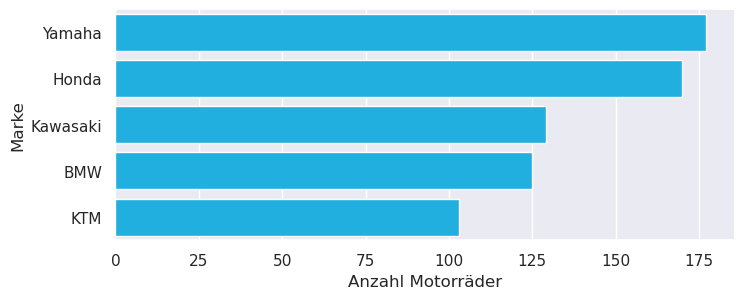

In [22]:
# Gruppierung nach Marke mit absteigender Sortierung
vehicles_count = df.groupby("Marke").size().sort_values(ascending=False)
sns.set_theme()
_, ax = plt.subplots(figsize=(8, 3))
# Balkendiagramm
sns.barplot(ax=ax, x=vehicles_count.values, y=vehicles_count.index, color="deepskyblue")
ax.set(xlabel="Anzahl Motorräder", ylabel="Marke")
plt.show()

Wie man sieht, sind im Datensatz mit über 175 Einträgen die meisten Fahrzeuge von Yamaha. Dass Honda und Kawasaki folgen, unterstreicht die Dominanz der japanischen Hersteller auf dem Motorradmarkt, auch wenn man diese Zahlen nicht mit Neuzulassungen in Verbindung setzen darf.

### Wie ist die Leistung in PS bei den verschiedenen Marken vertreten?

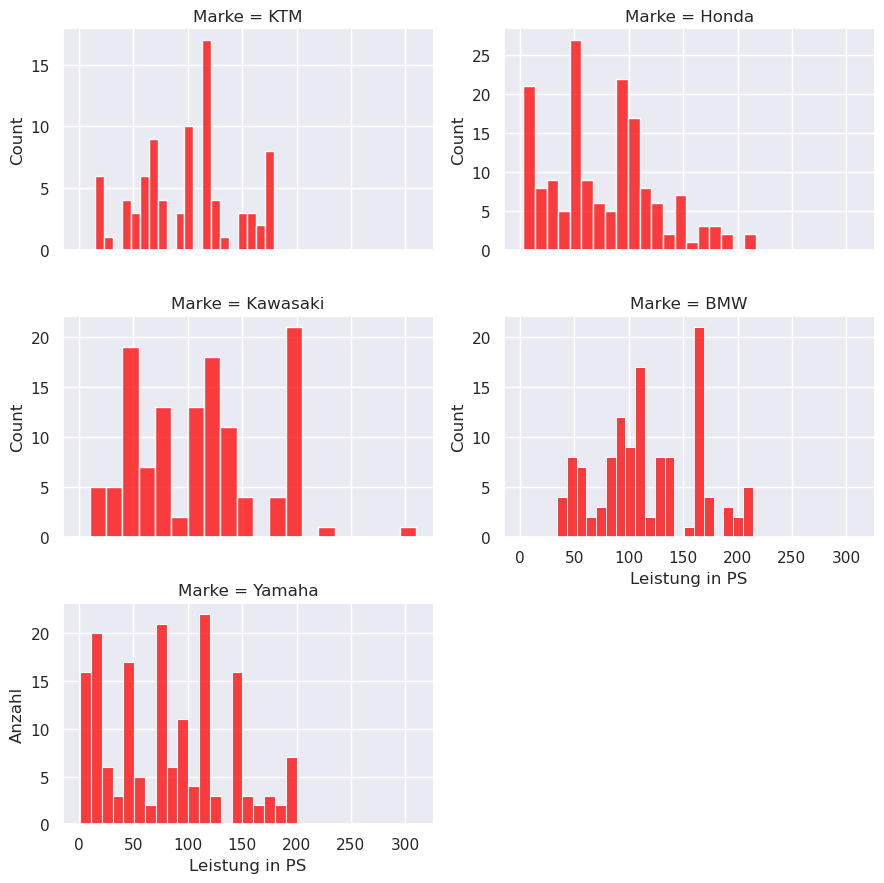

In [23]:
# FacetGrid um mehrere Plots anzuzeigen
# NaN-Values werden entfernt und die X-Achse auf allen Plots geteilt, um bei der Leistung einen bessere visuelle Vergleichbarkeit zu gewährleisten
power_distribution_brands = sns.FacetGrid(df, col="Marke", col_wrap=2, aspect=3/2, dropna=True, sharex=True, sharey=False)

power_distribution_brands.map(sns.histplot, "Leistung in PS", color="red", bins=20)

plt.xlabel("Leistung in PS")
plt.ylabel("Anzahl")
plt.show()

Erkennbar aus den Histogrammen ist, dass die Marken leistungstechnisch alle breit aufgefächert sind. Bei Yamaha und Honda erkennt man, dass diese schon kurz nach 0 anfangen. Das liegt daran, dass diese Marken auch viele 50 cm³-Motorroller produzieren, welche oft nur ca. 3 PS haben.

In [24]:
ccm_yamaha_honda = df.loc[df["Marke"].isin(["Yamaha", "Honda"]), "Hubraum in ccm"]
count_50ccm = ccm_yamaha_honda[ccm_yamaha_honda <= 50].count()
print(f"Anzahl der Fahrzeuge von Yamaha und Honda mit einem Hubraum bis 50 cm³: {count_50ccm}")

Anzahl der Fahrzeuge von Yamaha und Honda mit einem Hubraum bis 50 cm³: 13


BMW hat auffällig viele Modelle mit mehr als 150 PS und kaum etwas unter 50 PS.
Kawasaki bietet, wie bereits erwähnt einige der stärksten Motorräder auf dem Markt an, wie beispielsweise die Ninja H2-R (310 PS), erkennbar an dem Balken kurz nach 300 PS.

Eine interessante Erkennung ist bei KTM vorzufinden. Es gibt nur Einträge unter 200 PS. Doch warum ist das so? Dazu untersuche ich nun, was die Marken für Motoren verbauen, genauer gesagt wie viele Zylinder sie haben.

### Vergleich der Zylinderzahlen

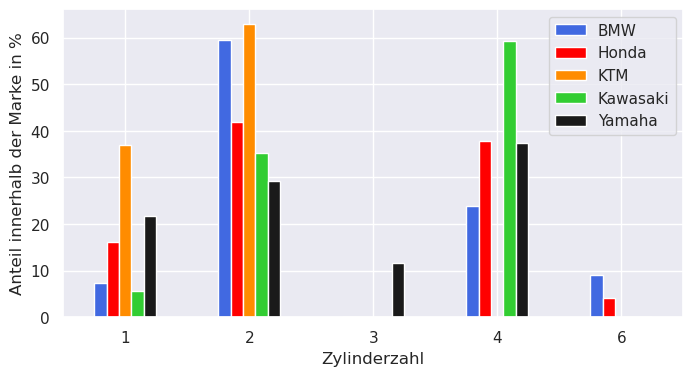

In [29]:
cylinders_df = df[["Marke", "Zylinderzahl"]].groupby("Marke").value_counts(dropna=True).to_frame("Anzahl").reset_index()
# Umwandlung in Integer, jetzt wo es keine NaN-Werte mehr gibt
cylinders_df["Zylinderzahl"] = cylinders_df["Zylinderzahl"].astype(int)

def anteil_innerhalb_marke(marke):
    marke["Gesamtanzahl"] = marke["Anzahl"].sum()
    marke["Anteil innerhalb der Marke in %"] = (marke["Anzahl"] / marke["Gesamtanzahl"]) * 100
    return marke

# Prozentsatz der Motoren mit der Zylinderanzahl innerhalb der Marken berechnen
cylinders_df = cylinders_df.groupby("Marke", group_keys=False).apply(anteil_innerhalb_marke)
cylinders_df = cylinders_df.drop(columns=["Anzahl", "Gesamtanzahl"])


# Farben für die Marken festlegen
COLOR_BMW = "royalblue"
COLOR_HONDA = "red"
COLOR_KTM = "darkorange"
COLOR_KAWASAKI = "limegreen"
COLOR_YAMAHA = "k"


_, ax = plt.subplots(figsize=(8, 4))
# Säulendiagramm gruppiert nach Zylinderzahl für jede Marke
cylinders_df.groupby(["Zylinderzahl", "Marke"]).mean().unstack().plot(
    kind="bar", ax=ax,
    color=(COLOR_BMW, COLOR_HONDA, COLOR_KTM, COLOR_KAWASAKI, COLOR_YAMAHA),
)
# Label für die y-Achse setzen
ax.set_ylabel(cylinders_df["Anteil innerhalb der Marke in %"].name)
# x-labels haben eine Rotation, die ich entferne
ax.tick_params(axis="x", rotation=0)
# Legende soll nur die Marken enthalten
ax.legend(cylinders_df["Marke"].drop_duplicates().values)
plt.show()

Wie man sieht, sind Ein-, Zwei- und Vier-Zylinder-Motoren am meisten unter diesen fünf Marken vertreten. Kawasaki hat besonders viele Vierzylinder, während die Verteilung bei Yamaha und Honda relativ ausgeglichen ist.

Diese Grafik gibt und allerdings möglicherweise auch die Lösung auf die Frage, warum KTM nur Motorräder unter 200 PS anbietet: Sie haben nur Ein- und Zweizylinder. 

Doch gibt es wirklich einen merklichen Zusammenhang zwischen der Anzahl der Zylinder und der Leistung, selbst wenn der Hubraum gleich ist?

### Wie hängen Leistung pro Hubraum und Anzahl der Zylinder miteinander zusammen?

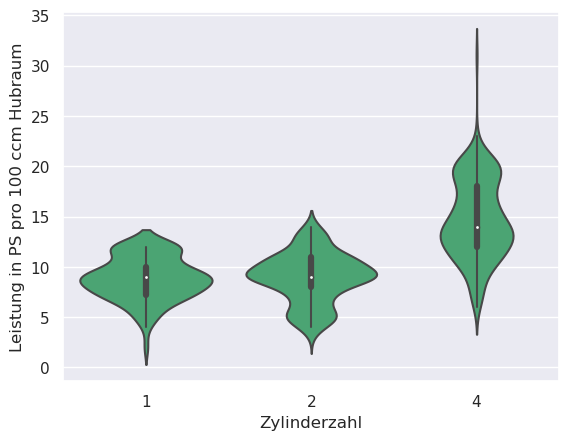

In [30]:
df["Leistung in PS pro 100 ccm Hubraum"] = df["Leistung in PS"] / df["Hubraum in ccm"] * 100

# Da es wenig Daten zu 3- und 6-Zylinder-Motoren gibt, werden diese nicht beachtet
filtered_df = df[(df["Zylinderzahl"] != 3) & (df["Zylinderzahl"] != 6)]
filtered_df = filtered_df.filter(["Zylinderzahl", "Leistung in PS pro 100 ccm Hubraum"]).dropna().astype(int)

sns.violinplot(data=filtered_df, x="Zylinderzahl", y="Leistung in PS pro 100 ccm Hubraum", color="mediumseagreen")
plt.show()

Hier lässt sich sehr gut erkennen, wie sich die Dichte, sowie die Minimal- und Maximalwerte nach oben verschieben, je mehr Zylinder vorhanden sind. Die Maximalwerte zeigen, dass mehr Zylinder zu einer höheren Leistung pro Hubraum fähig sind, während die Dichte zeigt, dass die meisten Fahrzeuge einer höheren Zylinderklasse auch durchschnittlich mehr Leistung hervorbringen.

Das ist auch logisch, denn mehr Zylinder bedeuten weniger Hubraum pro Zylinder, da dieser sich auf alle Zylinder aufteilt. Durch die kleineren Zylinder und dazugehörigen Bauteile können somit höhere Drehzahlen erreicht werden.

Doch wie sollte man sich entscheiden, wenn man selbst überlegt mit dem Motorradfahren anzufangen?
Wichtige Aspekte für Anfänger sind vor allem der Preis und die Leistung, da man wahrscheinlich als Neuling nicht allzu viel Geld ausgeben möchte und sich auch nicht gleich mit zu viel Leistung überfordern sollte. Aber auch andere Parameter können den Preis beeinflussen.

Um einen Überblick zu bekommen, schauen wir uns nun Motorräder im Leistungsbereich von 20 bis 170 PS an. Den Bereich habe ich so gewählt, da er meiner Meinung nach für Einsteiger nicht langweilig ist, aber auch nicht zu sehr überfordern sollte.

### Welche Parameter beeinflussen bei Motorrädern zwischen 20 und 170 PS den Preis?

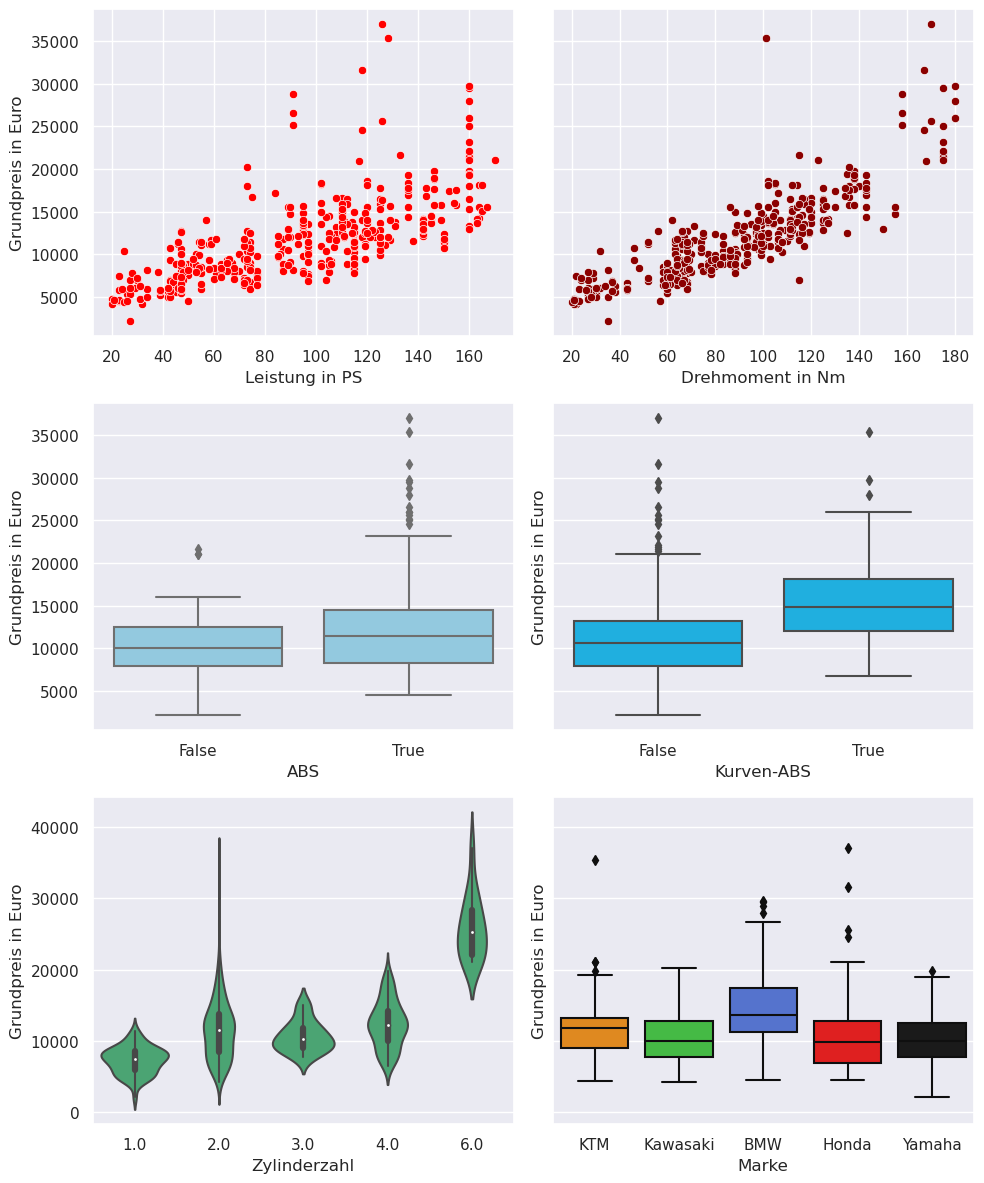

In [31]:
filtered_df = df[df["Grundpreis in Euro"].notna()]

def remove_outliers(df: pd.DataFrame, col_name: str):
    # Werte außerhalb der dreifachen Standardabweichung entfernen
    mean = df[col_name].mean()
    std = df[col_name].std()
    return df[(df[col_name] <= mean + (3 * std))]


filtered_df = remove_outliers(filtered_df, "Grundpreis in Euro")
filtered_df = remove_outliers(filtered_df, "Jahr")

# Entfernen von Fahrzeugen unter 20 PS und über 120 PS
filtered_df = filtered_df[filtered_df["Leistung in PS"].between(20, 170)]

fig, axs = plt.subplots(3, 2, figsize=(10, 12), sharey="row")

sns.scatterplot(data=filtered_df, x="Leistung in PS", y="Grundpreis in Euro", ax=axs[0, 0], color="red")
sns.scatterplot(data=filtered_df, x="Drehmoment in Nm", y="Grundpreis in Euro", ax=axs[0, 1], color="darkred")
sns.boxplot(data=filtered_df, x="ABS", y="Grundpreis in Euro", ax=axs[1, 0], color="skyblue")
sns.boxplot(data=filtered_df, x="Kurven-ABS", y="Grundpreis in Euro", ax=axs[1, 1], color="deepskyblue")
sns.violinplot(data=filtered_df, x="Zylinderzahl", y="Grundpreis in Euro", ax=axs[2, 0], color="mediumseagreen")
sns.boxplot(data=filtered_df, x="Marke", y="Grundpreis in Euro", ax=axs[2, 1], palette=[COLOR_KTM, COLOR_KAWASAKI, COLOR_BMW, COLOR_HONDA, COLOR_YAMAHA])

fig.tight_layout()
plt.show()

Wie man sieht, ändern sich manche Parameter mehr und manche weniger mit dem Preis.

Anhand der Diagramme mit der Leistung und dem Drehmoment sieht man deutlich, dass stärkere Motorräder teurer sind.

Auch ABS ist bei teureren Modellen öfter vorhanden, wobei hier der Unterschied im Interquartilsabstand nur gering ist. Viel deutlicher ist die Differenz bei Motorrädern mit Kurven-ABS, welches scheinbar viel öfter bei teuren Motorrädern vorhanden ist. Es benötigt beispielsweise auch einen Schräglagensensor, womit die Kosten für die Herstellung des Fahrzeugs steigen würden.

Bei der Zylinderzahl fällt auf, dass Einzylinder mit Abstand am günstigsten sind. Umgekehrt sind Sechszylinder besonders teuer, wobei das Ergebnis jedoch auch eine Messungenauigkeit aufgrund der kleinen Datengrundlage sein kann.

Bei den Marken siedelt sich Yamaha mit einem kleinen Teil des Sortimentes bei bereits unter 5000 Euro an, bietet darüber hinaus, genau wie Honda, jedoch auch viele Modelle im relativ günstigen Bereich an. Anders sieht es bei BMW aus, dort befinden sich die meisten Motorräder zwischen ca. 11000 und 18000 Euro.

## Fazit
Für Anfänger, die günstig in das Motorradfahren einsteigen möchten, könnte es sich lohnen, nach Motorrädern von Yamaha mit etwas weniger Leistung und nur einem Zylinder zu suchen.

Über den Datensatz lässt sich sagen, dass er leider nicht allzu groß ist, weil er nicht alle Motorräder enthält, die es gibt. Daraus folgend musste ich in einigen Berechnungen auf eine ausreichende Datengrundlage achten. Er enthält jedoch sehr viele Spalten, selbst nachdem ich einen großen Teil entfernt habe und bietet Potenzial für noch viel mehr Analysen, die allerdings für diese Seminararbeit den Rahmen sprengen würden.

Abgesehen davon war es sehr interessant zu sehen, in welchen Aspekten sich die Marken unterscheiden und dass KTM wirklich nur Ein- und Zweizylindermotoren im Angebot hat, welche dennoch mit bis zu 180 PS für Motorräder extreme Leistungen auf die Straße bringen.

## Quellen
### Informationen
https://www.sueddeutsche.de/wirtschaft/verkehr-maschinen-mit-200-ps-wie-viel-motorrad-braucht-der-mensch-dpa.urn-newsml-dpa-com-20090101-150213-99-02360

https://de.wikipedia.org/wiki/Daimler-Reitwagen

https://de.wikipedia.org/wiki/Motorrad

https://de.wikipedia.org/wiki/Suzuki_Hayabusa_1300

https://www.youtube.com/watch?v=6_n7ru1e-rg&ab_channel=DenProHD

https://auto360.de/bugatti-chiron-faehrt-weltrekord-0-400-0-kmh-in-42-sekunden


### Datensatz
https://www.motorradonline.de/marken-modelle/

https://www.motorradonline.de/marken-modelle/[MARKE]/

https://www.motorradonline.de/marken-modelle/[MARKE]/[MODELL]/technische-daten/

Datenstand: 2023-01-13